In [ ]:
%pip install qiskit-aer
%pip install seaborn
%pip install pylatexenc


In [414]:
import numpy as np
from quam_libs.components import QuAM, TransmonPair
from quam_libs.experiments.two_qubit_xeb import (
    XEBConfig,
    XEB,
    backend as fake_backend,
    QUAGate,
)

machine = QuAM.load()
qubits = machine.active_qubits
# Get the relevant QuAM components
readout_qubit_indices = [0,1,2,3,4]  # Indices of the target qubits
readout_qubits = [qubits[i] for i in readout_qubit_indices]
target_qubit_indices = [0,1,2,3,4]  # Indices of the target qubits
target_qubits = [qubits[i] for i in target_qubit_indices]
target_qubit_pairs = [
    qubit_pair
    for qubit_pair in machine.active_qubit_pairs
    if qubit_pair.qubit_control in target_qubits and qubit_pair.qubit_target in target_qubits

]

from qm.qua import frame_rotation_2pi, align
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)

def cz_gate(qubit_pair: TransmonPair):
    """
    CZ gate QUA macro: Add your own QUA code here implementing your CZ gate for any given qubit pair
    :param qubit_pair: TransmonPair instance on which to apply the gate
    :return: None
    """

    q1 = qubit_pair.qubit_control # flux-tuned-down-qubit (flux-tuned)
    q2 = qubit_pair.qubit_target # flux-tuned-up-qubit (to-meet-with)  

    if q1.id=="q5" and q2.id=="q4": phi_to_flux_tune, phi_to_meet_with = 2.306, 2.340
    if q1.id=="q3" and q2.id=="q4": phi_to_flux_tune, phi_to_meet_with = 1.713, 2.448
    if q1.id=="q3" and q2.id=="q2": phi_to_flux_tune, phi_to_meet_with = 0.844, 0.49
    if q1.id=="q1" and q2.id=="q2": phi_to_flux_tune, phi_to_meet_with = 0.043, -0.562

    q1.z.play("cz%s_%s"%(q1.name.replace("q",""),q2.name.replace("q","")))
    qubit_pair.coupler.play("cz")
    align(q1.z.name, qubit_pair.coupler.name, q1.xy.name, q2.xy.name)
    # align()
    frame_rotation_2pi(phi_to_flux_tune, q1.xy.name)
    frame_rotation_2pi(phi_to_meet_with, q2.xy.name)
    align()


cz_qua = QUAGate("cz", cz_gate)

xeb_config = XEBConfig(
    seqs=188, #81,
    # depths=np.arange(1, 1200, 24),
    depths=np.arange(1, 640, 10),
    n_shots=512, #1000,
    readout_qubits=readout_qubits, 
    qubits=target_qubits,
    qubit_pairs=target_qubit_pairs,
    baseline_gate_name="x90",
    gate_set_choice="sw",
    two_qb_gate=None, #cz_qua, None
    save_dir="",
    should_save_data=False, #True,
    generate_new_data=True,
    disjoint_processing=False, #False,
    # reset_method="active",
    # reset_kwargs={"max_tries": 3, "pi_pulse": "x180"},
    reset_method="cooldown", #"active",
    reset_kwargs={"cooldown_time": 100000, "max_tries": 3, "pi_pulse": "x180"},
)

print("target_qubits: %s" %[q.name for q in target_qubits]) 
# print("qubit_control: %s" %(qubits[0]@qubits[1]).qubit_control)
xeb_runtime = xeb_config.seqs * len(xeb_config.depths) * xeb_config.n_shots / (150 * 27 * 700) * 19.35
print("time required: %s min" % (xeb_runtime))


target_qubits: ['q1', 'q2', 'q3', 'q4', 'q5']
time required: 42.0470653968254 min


In [415]:
simulate = False  # Set to True to simulate the experiment with Qiskit Aer instead of running it on the QPU
xeb = XEB(xeb_config, quam=machine)
if simulate:
    job = xeb.simulate(backend=fake_backend)
else:
    job = xeb.run(simulate=False)  # If simulate is False, job is run on the QPU, else pulse output is simulated


2024-12-05 17:13:24,687 - qm - INFO     - Performing health check
2024-12-05 17:13:24,702 - qm - INFO     - Cluster healthcheck completed successfully.
2024-12-05 17:13:26,888 - qm - INFO     - Adding program to queue.


In [416]:
for qubit_pair in target_qubit_pairs: 
    print("qubit_control: %s" %qubit_pair.qubit_control)
    print("qubit_target: %s" %qubit_pair.qubit_target)
    print(qubit_pair.qubit_target.id)

print("Qubits: %s" % ", ".join([q.name for q in target_qubits]))
print("sequences: %s" % xeb_config.seqs)
print("shots: %s" % xeb_config.n_shots)

qubit_control: Transmon(id='q1', xy=MWChannel(operations={'x180_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=0, amplitude=0.16341987647269243, alpha=-0.7828317407801136, anharmonicity=205400000, detuning=0.0), 'x90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=0, amplitude=0.0810483193032584, alpha=-0.6235503408393649, anharmonicity=205400000, detuning=0.0), '-x90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=3.141592653589793, amplitude=0.0810483193032584, alpha=-0.6235503408393649, anharmonicity=205400000, detuning=0.0), 'y180_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=1.5707963267948966, amplitude=0.16341987647269243, alpha=-0.7828317407801136, anharmonicity=205400000, detuning=0.0), 'y90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=1.5707963267948966, amplitude=0.0810483193032584, alpha=-0.623550340839364

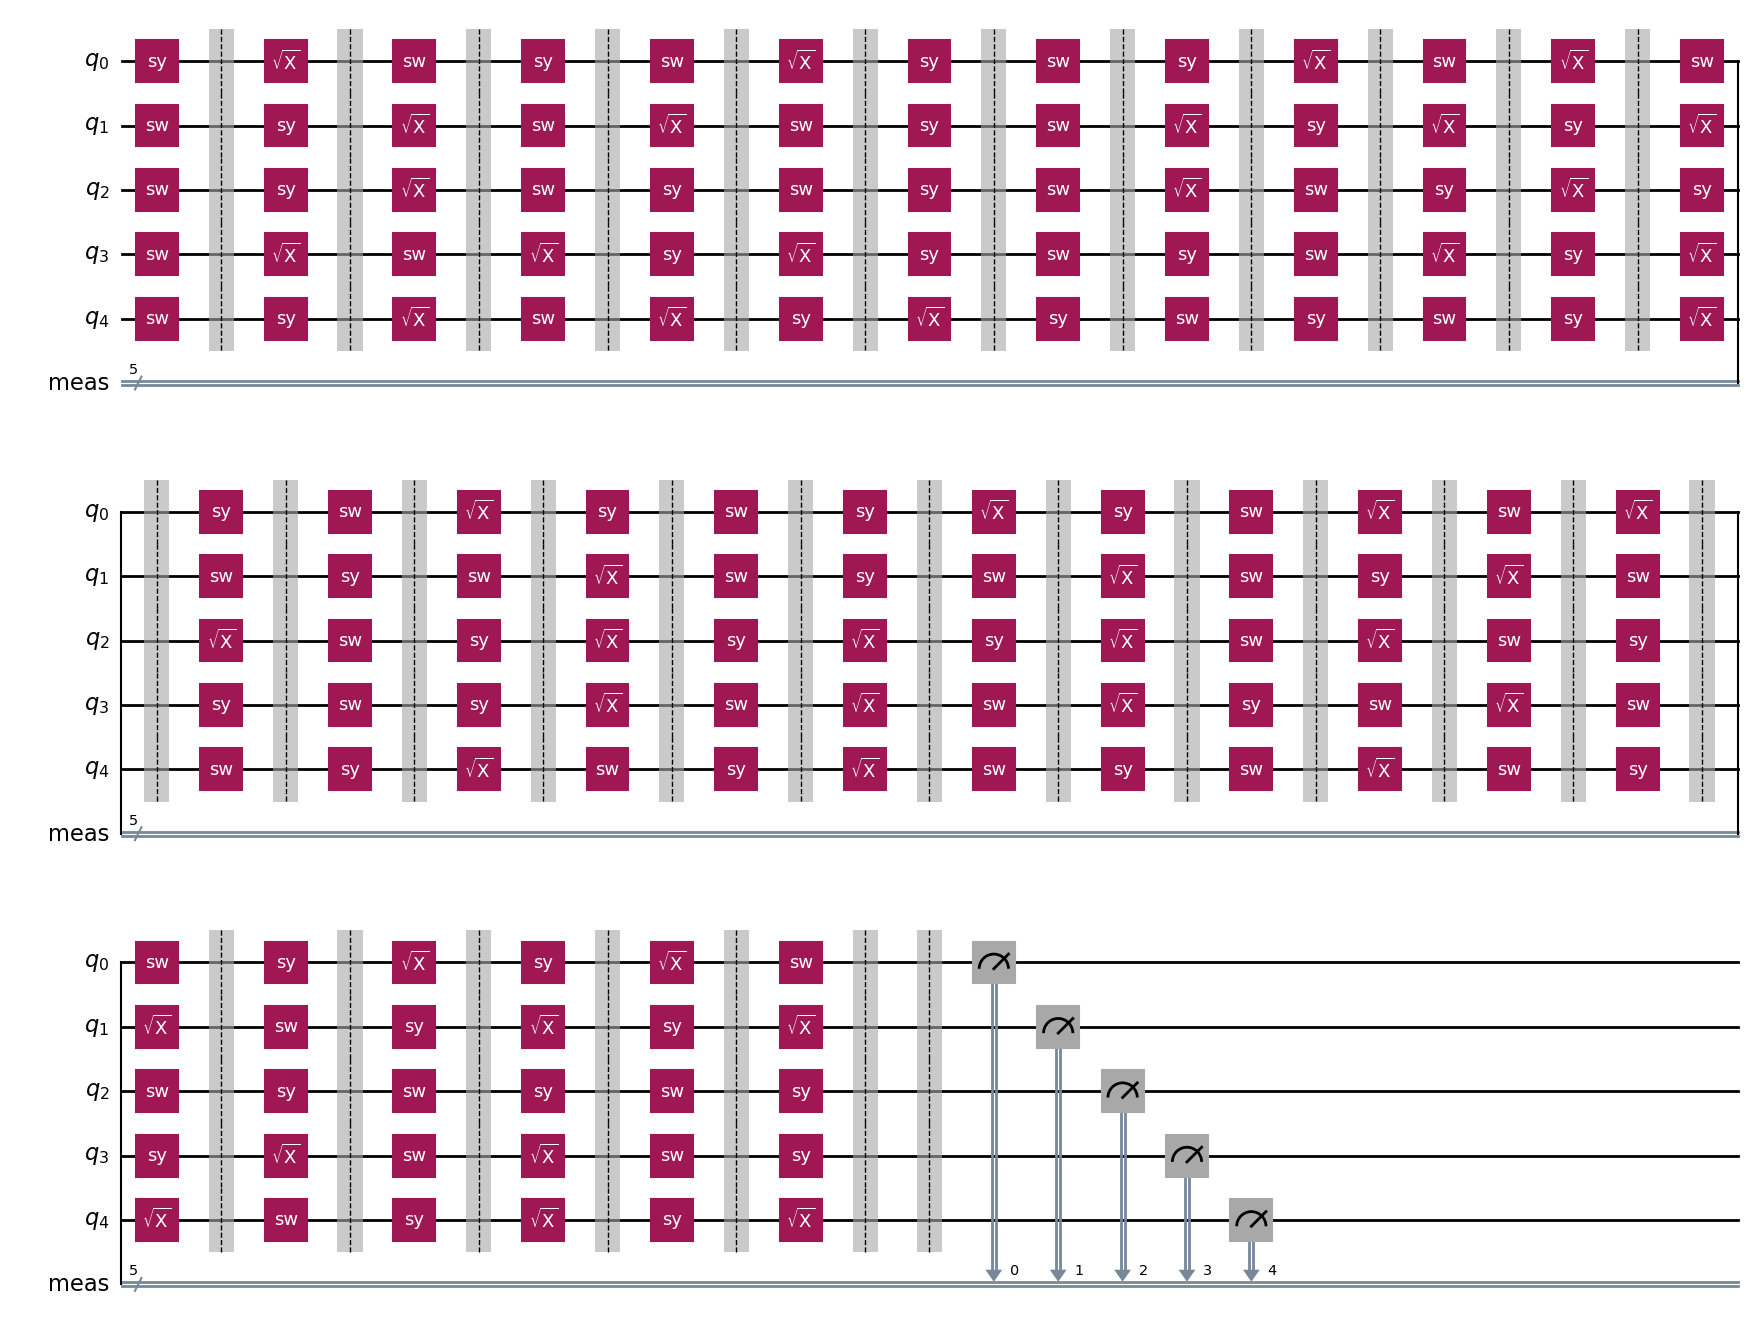

In [417]:
job.circuits[7][3].draw("mpl") # job.circuits[seq][depth] 

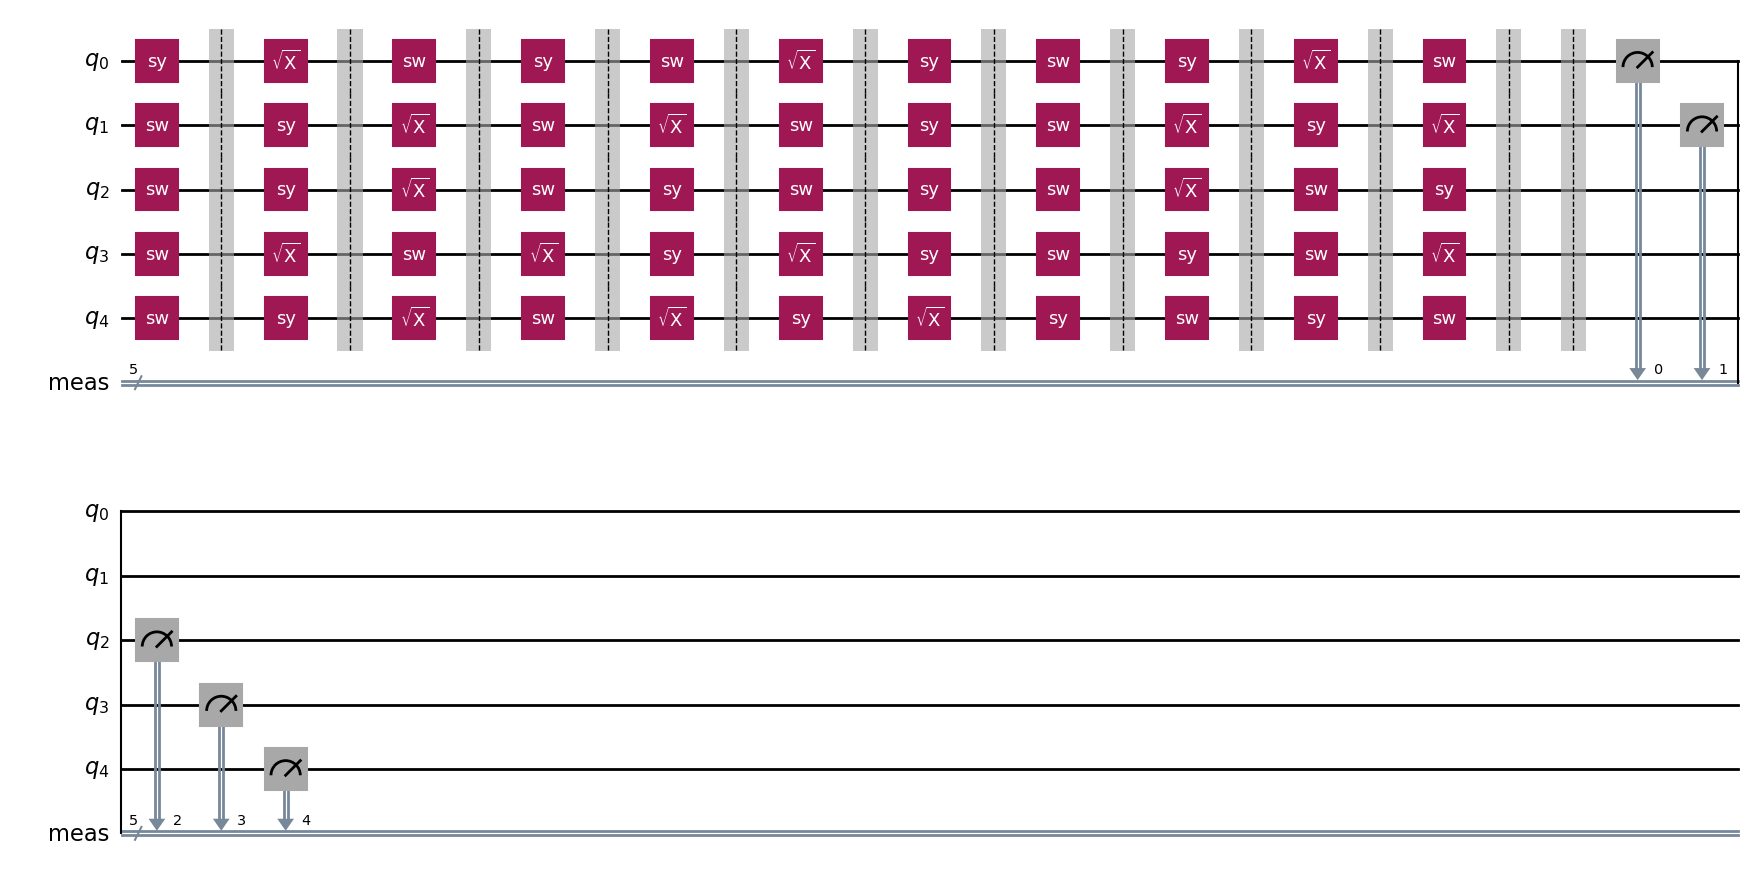

In [418]:
job.circuits[7][1].draw("mpl") # job.circuits[seq][depth]

/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:683: RuntimeWarning: invalid value encountered in scalar divide
  measured_probs = np.zeros((seqs, len(depths), dim))
/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:683: RuntimeWarning: divide by zero encountered in scalar divide
  measured_probs = np.zeros((seqs, len(depths), dim))
/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:735: RuntimeWarning: invalid value encountered in scalar divide
  )


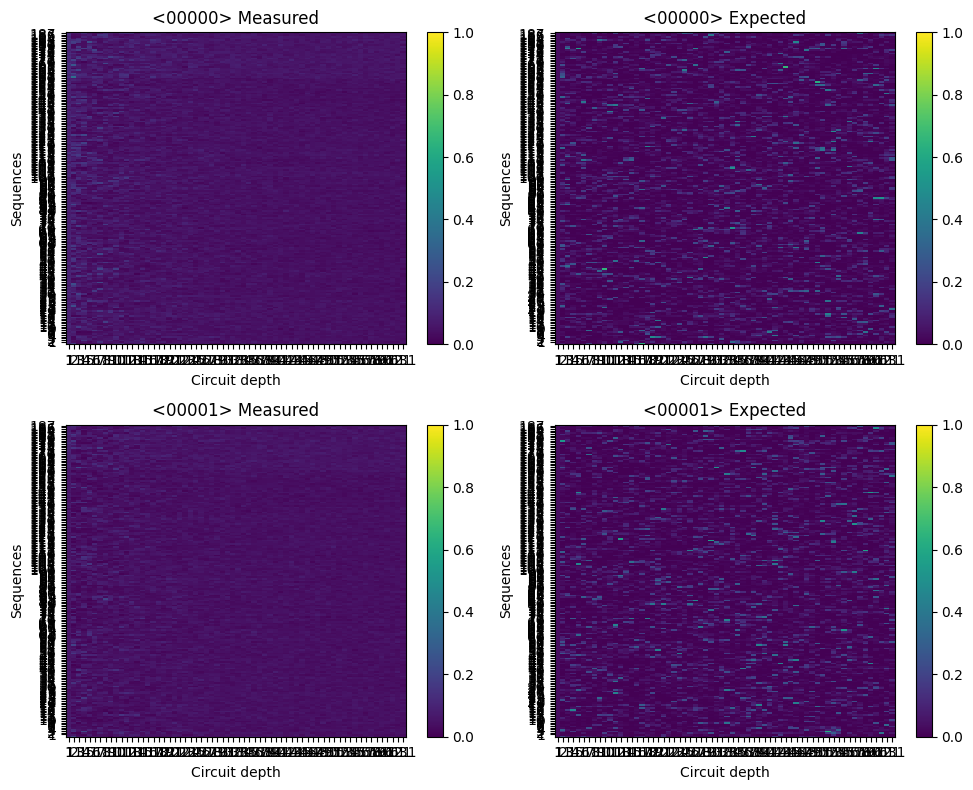

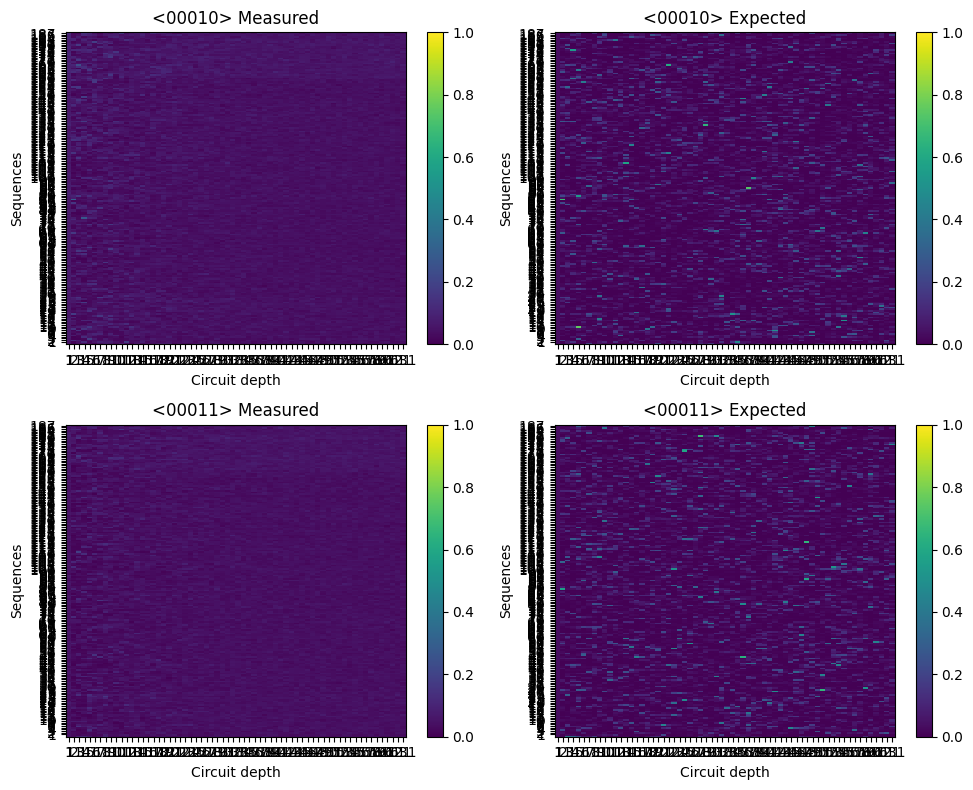

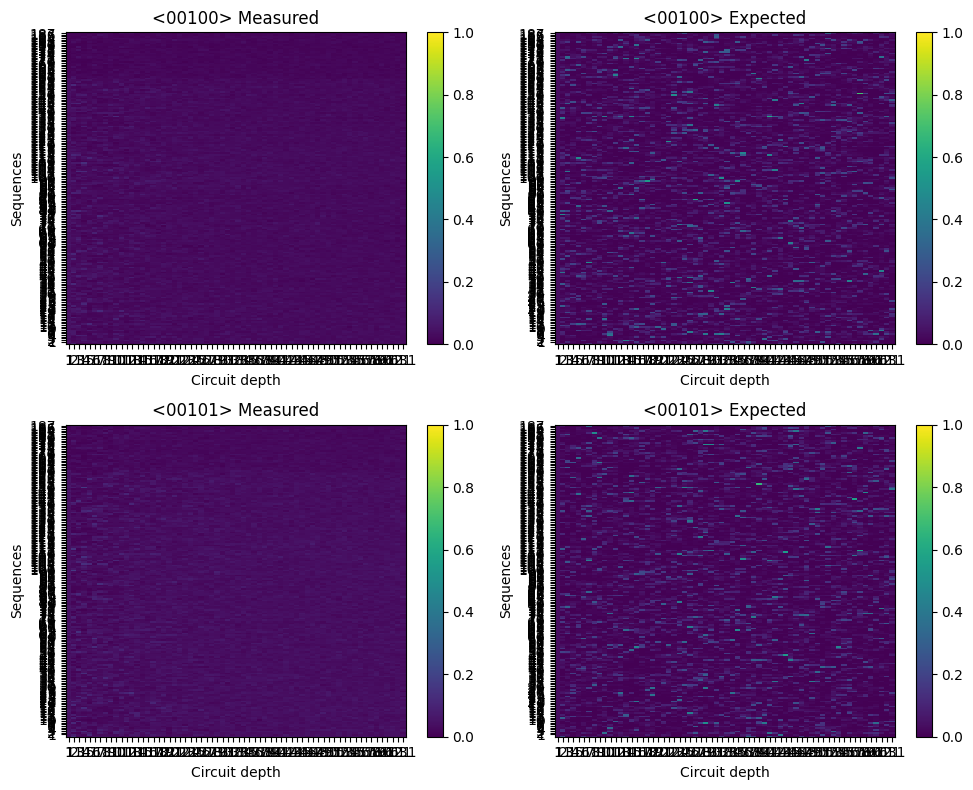

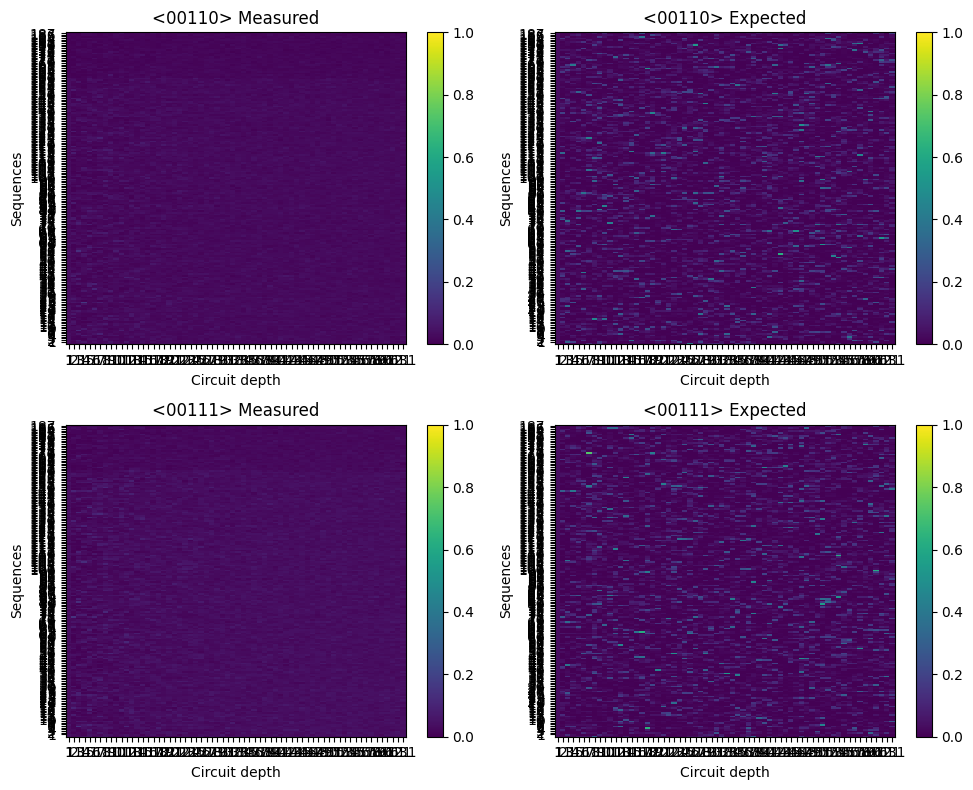

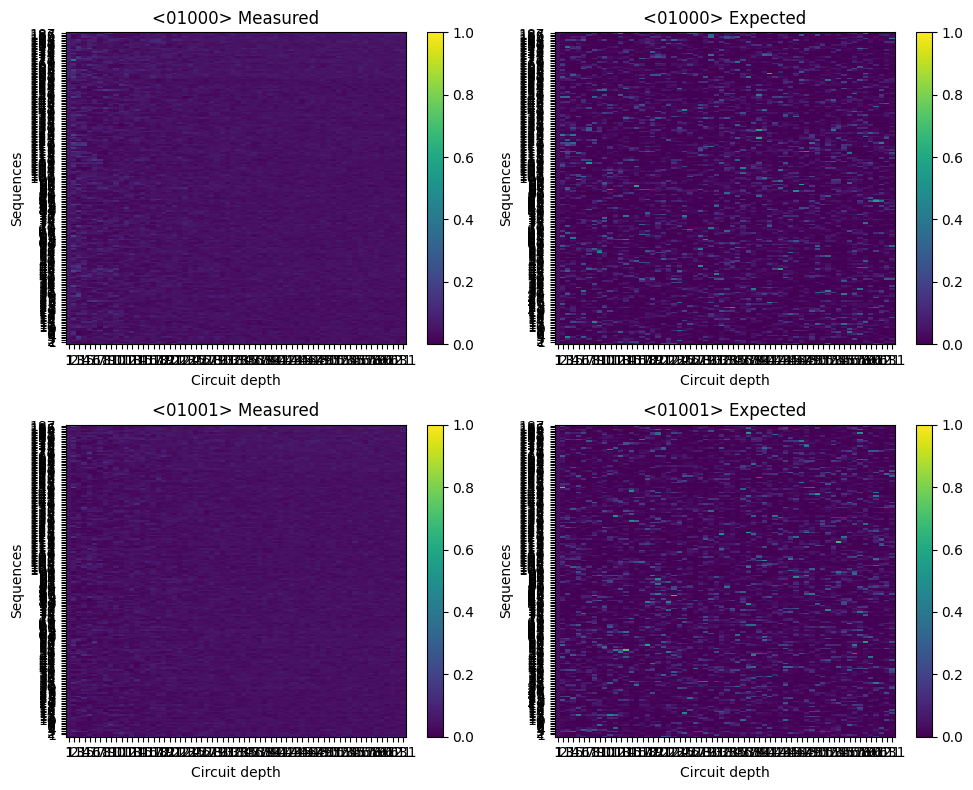

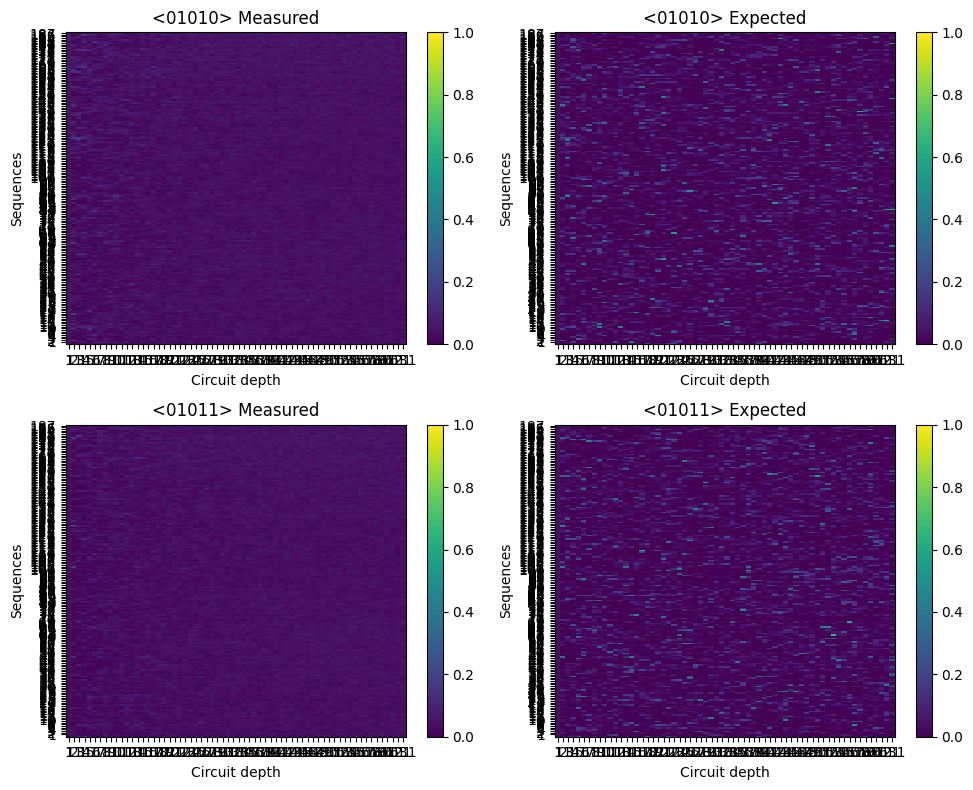

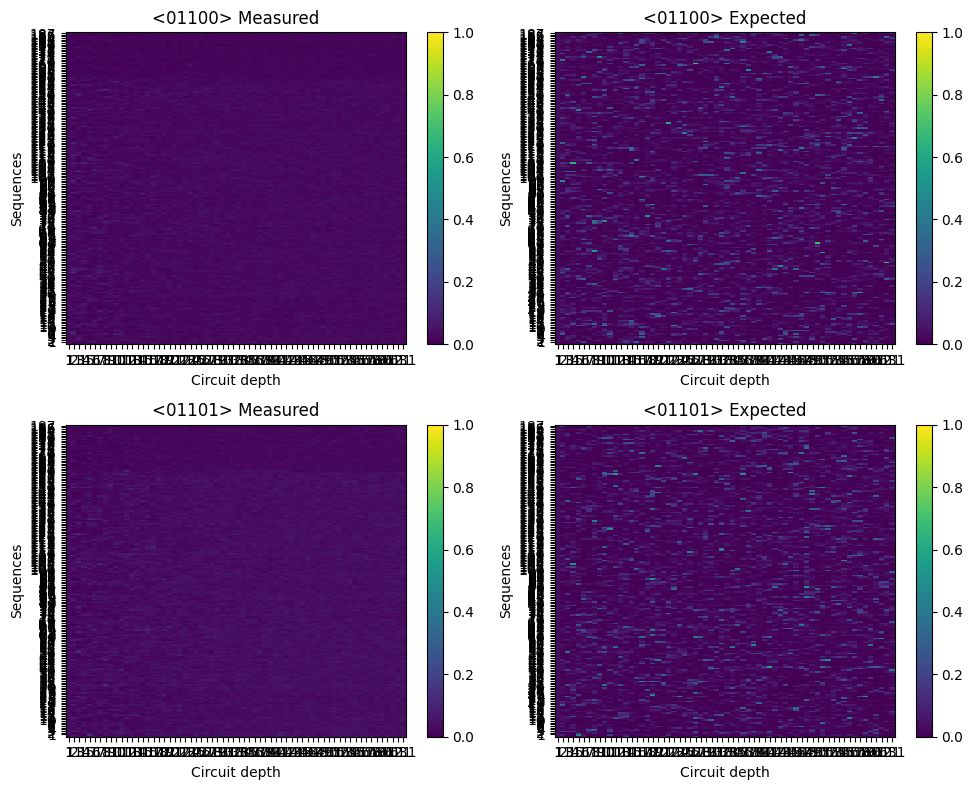

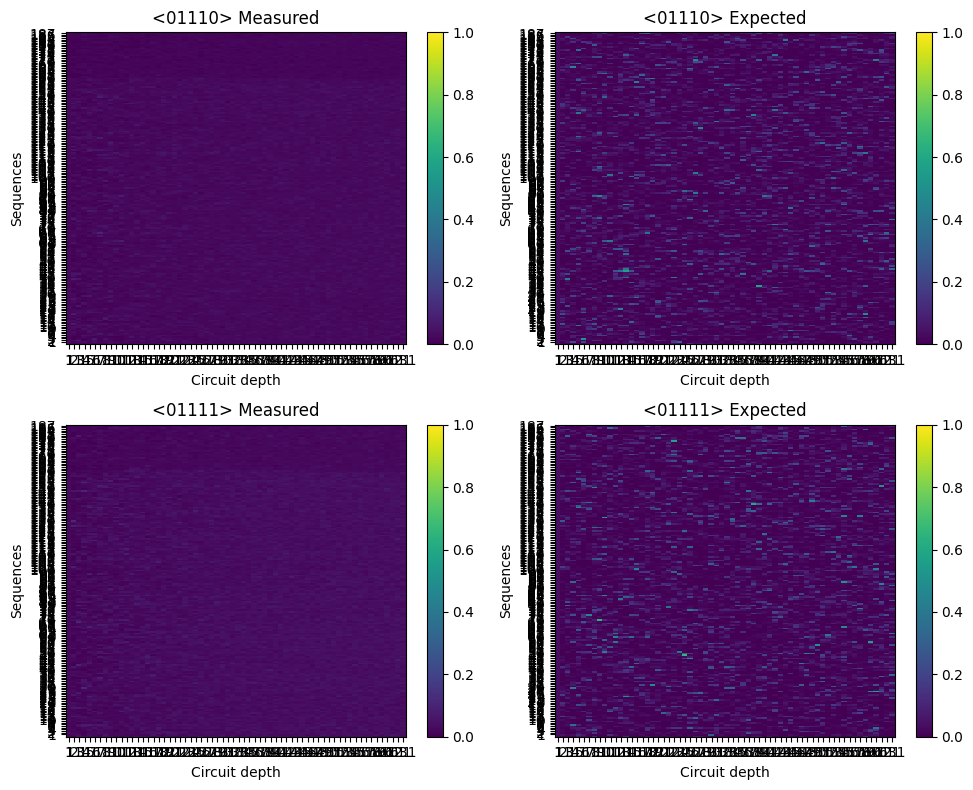

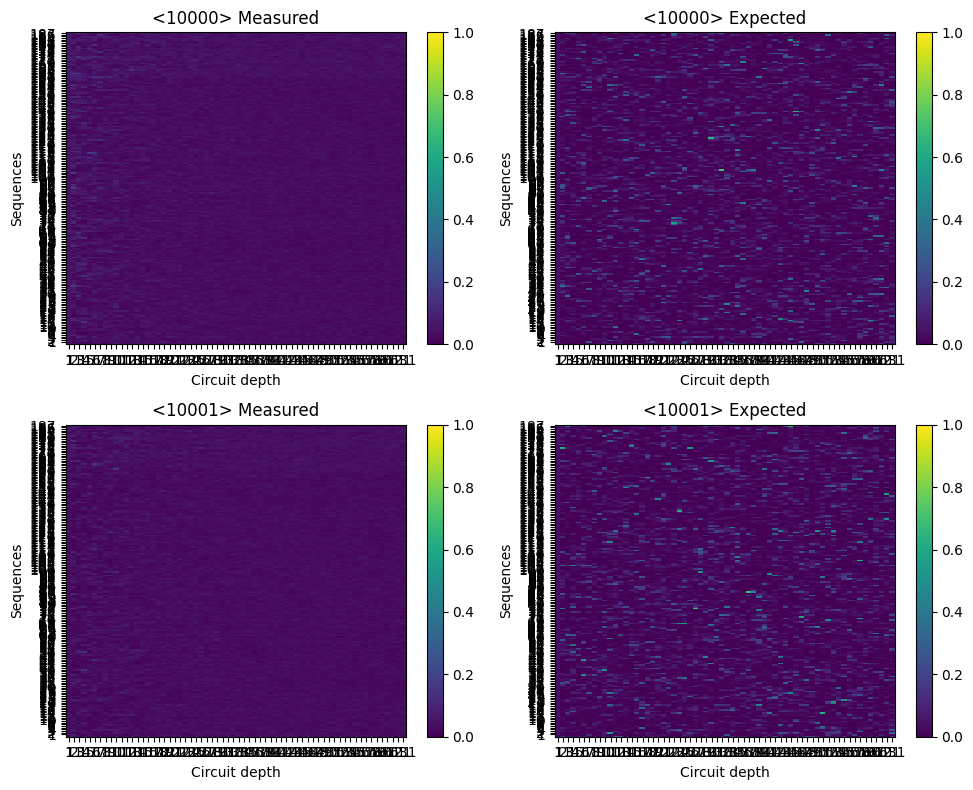

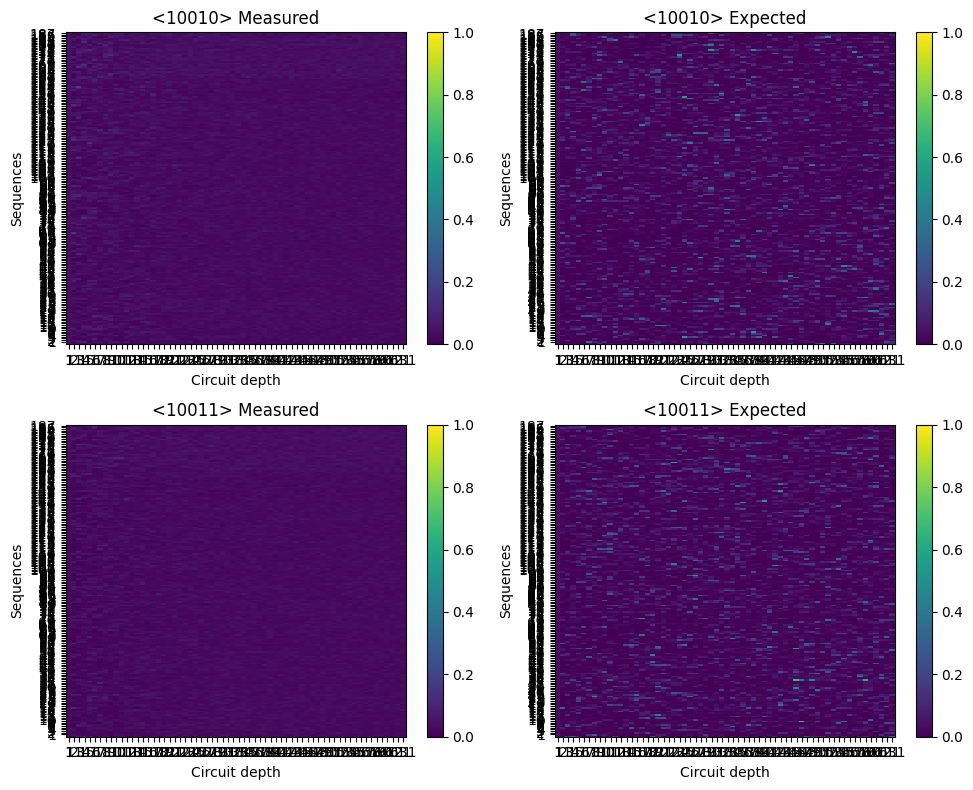

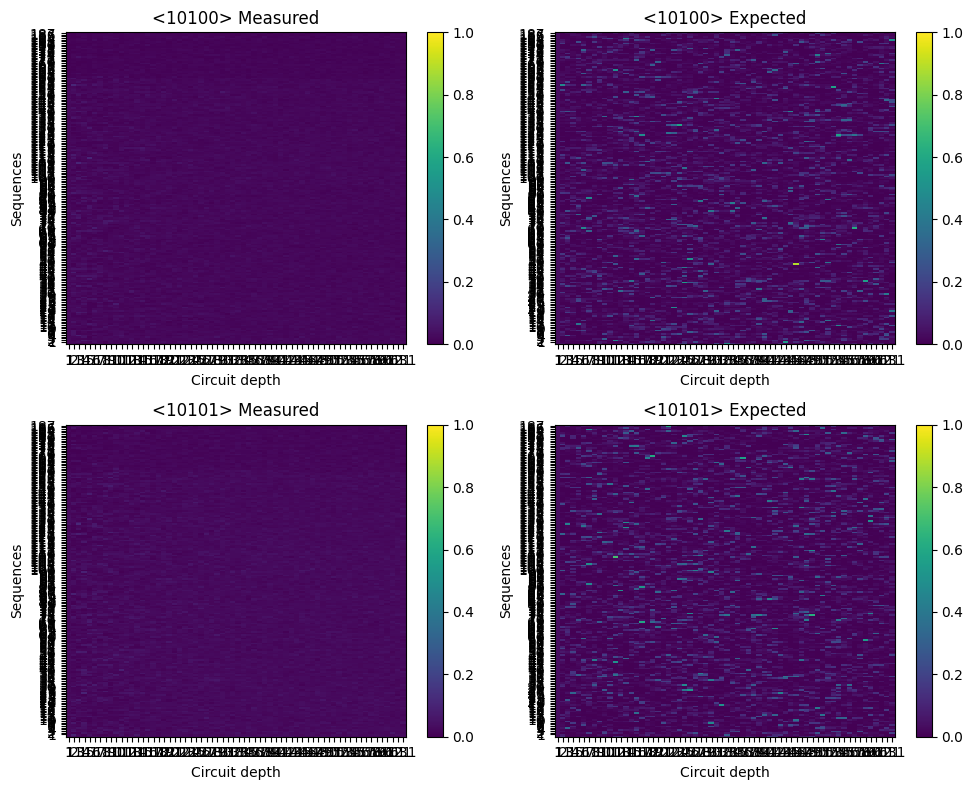

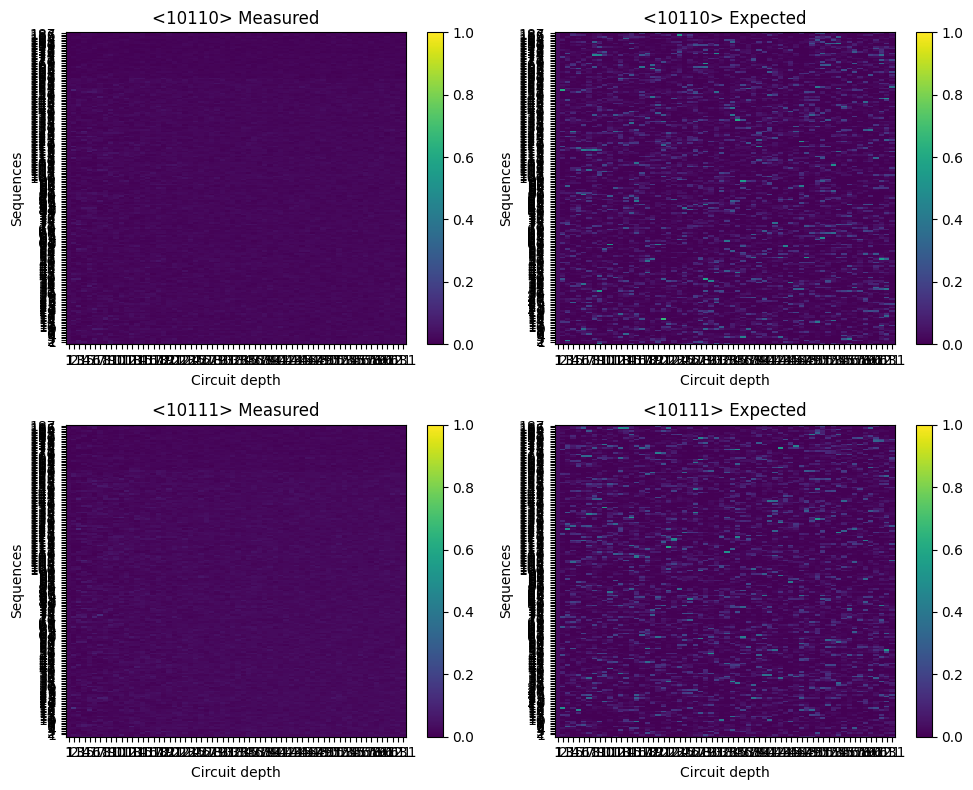

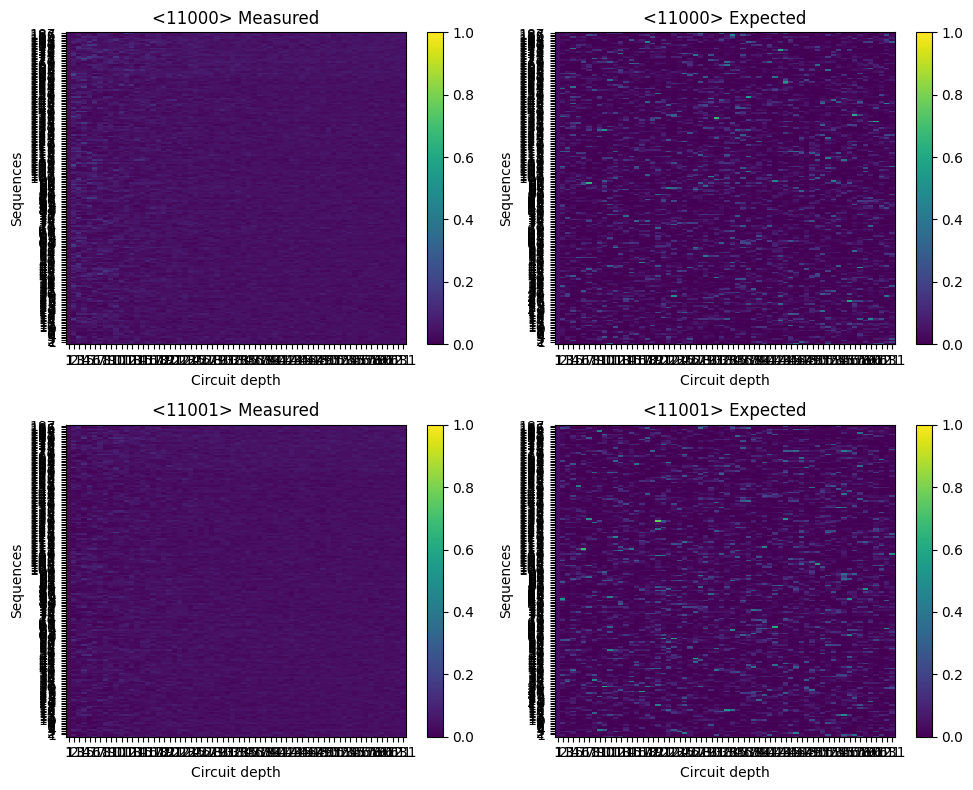

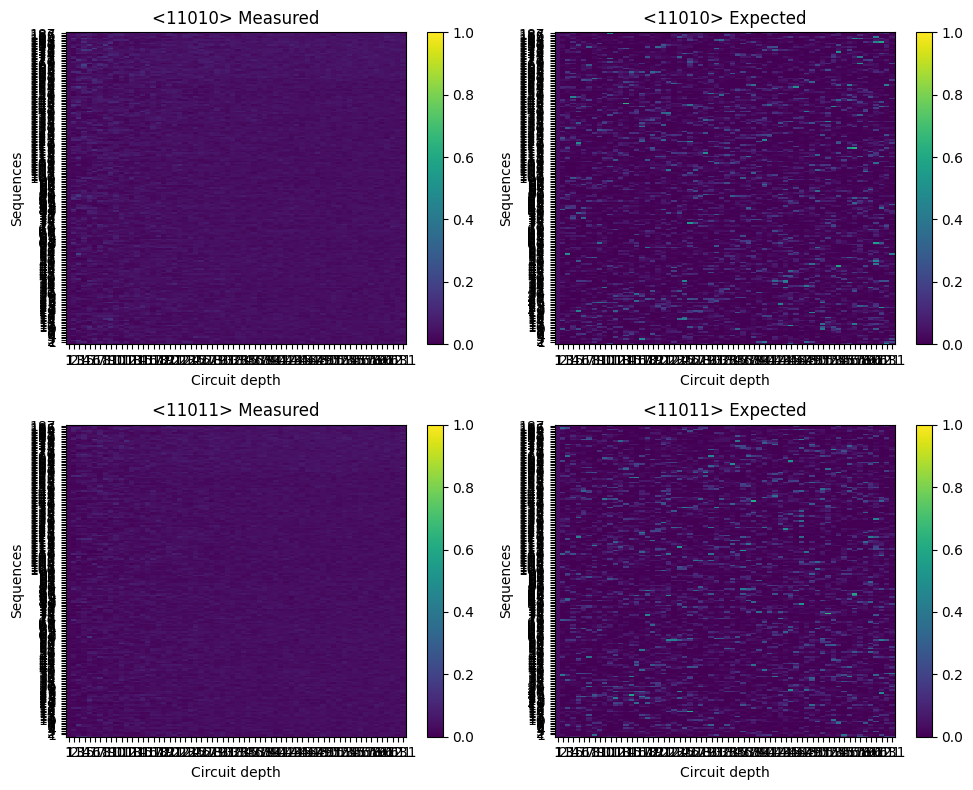

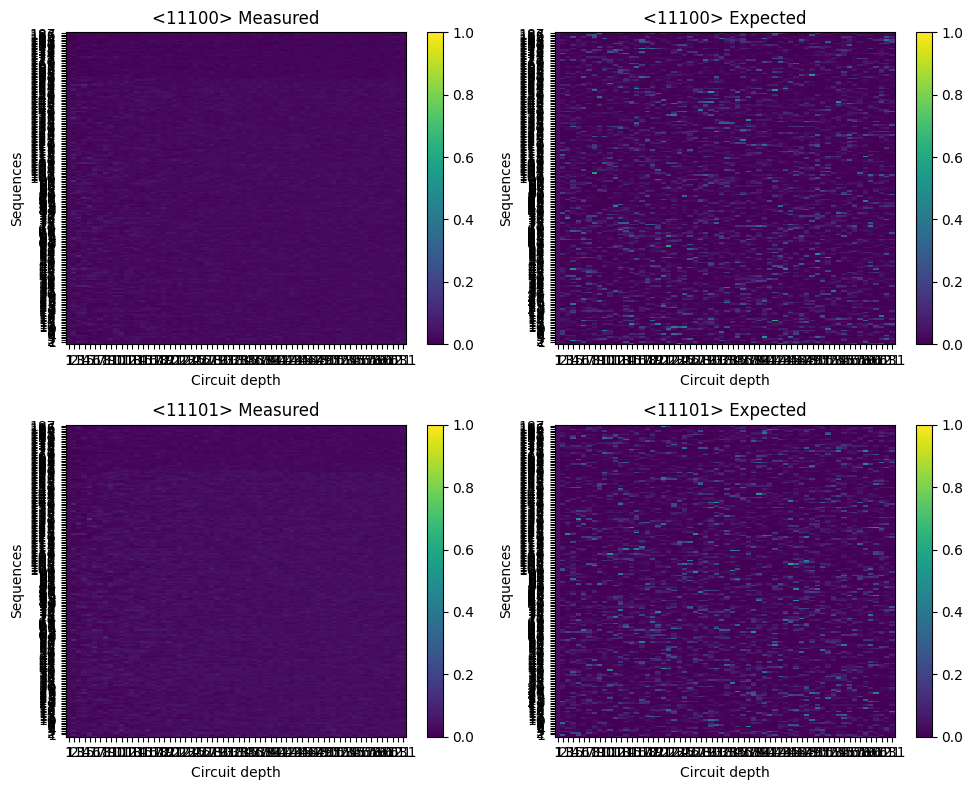

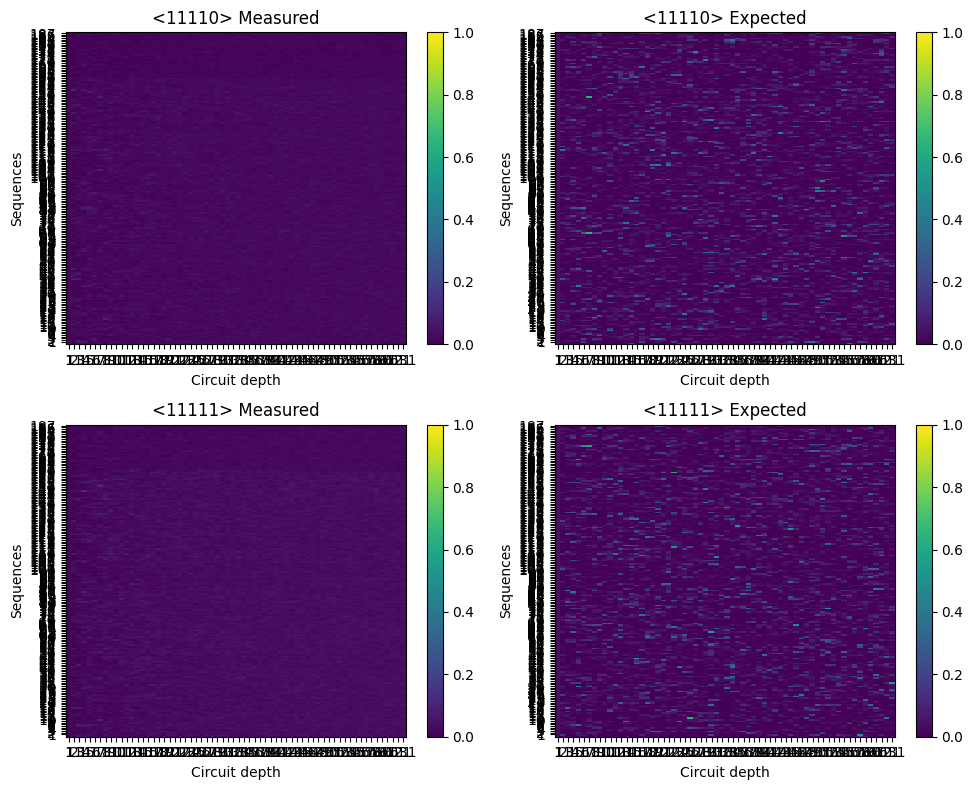

In [419]:
# 1. Extracting Outputs from QPU (QUA, Measured) 
# 2. Extracting recorded Circuits and perform ideal simulation accordingly on CPU (Expected): 
result = job.result()
result.plot_state_heatmap()

In [420]:
xeb.qubits

[Transmon(id='q1', xy=MWChannel(operations={'x180_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=0, amplitude=0.16341987647269243, alpha=-0.7828317407801136, anharmonicity=205400000, detuning=0.0), 'x90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=0, amplitude=0.0810483193032584, alpha=-0.6235503408393649, anharmonicity=205400000, detuning=0.0), '-x90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=3.141592653589793, amplitude=0.0810483193032584, alpha=-0.6235503408393649, anharmonicity=205400000, detuning=0.0), 'y180_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=1.5707963267948966, amplitude=0.16341987647269243, alpha=-0.7828317407801136, anharmonicity=205400000, detuning=0.0), 'y90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=1.5707963267948966, amplitude=0.0810483193032584, alpha=-0.6235503408393649, anharmonici

/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:920: RuntimeWarning: invalid value encountered in scalar divide
  


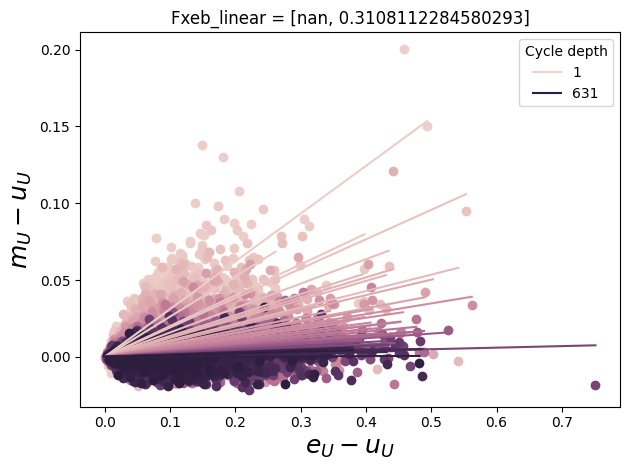

In [444]:
# Compute Fidelities:  
result.plot_records()


/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:870: RuntimeWarning: Mean of empty slice
  plt.scatter(


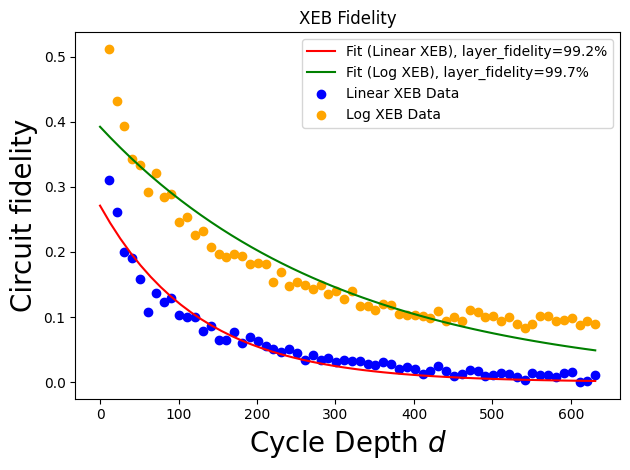

    depth  fidelity
0       1       NaN
1      11  0.310811
2      21  0.261912
3      31  0.200664
4      41  0.191447
..    ...       ...
59    591  0.013581
60    601  0.016015
61    611  0.000068
62    621  0.001412
63    631  0.011546

[64 rows x 2 columns]


In [446]:
result.plot_fidelities()
print(result.linear_fidelities)



fitting error: 0.9653%


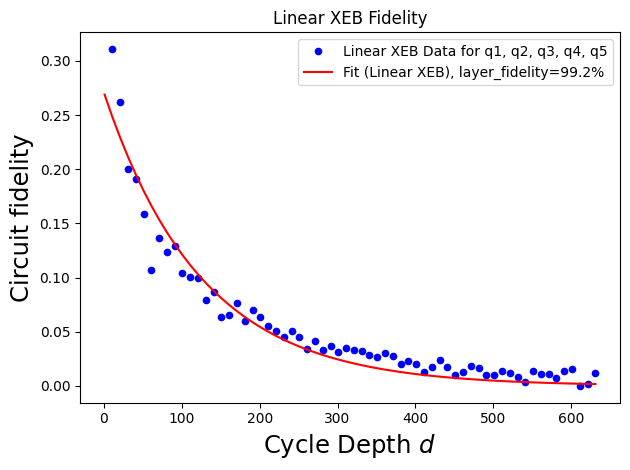

In [447]:
import pandas as pd
from matplotlib import pyplot as plt
df = pd.DataFrame(result.linear_fidelities)
plt.plot(df["depth"],df["fidelity"],'.b', markersize=9, label = "Linear XEB Data for %s" %", ".join([q.name for q in target_qubits]))

from quam_libs.experiments.two_qubit_xeb.macros import fit_exponential_decay, exponential_decay
(a_lin, layer_fid_lin, a_std_lin, layer_fid_std_lin,) = fit_exponential_decay(result.linear_fidelities["depth"], result.linear_fidelities["fidelity"])
plt.plot(df["depth"], exponential_decay(df["depth"], a_lin, layer_fid_lin),
label="Fit (Linear XEB), layer_fidelity={:.1f}%".format(layer_fid_lin * 100),
color="red",)

print("fitting error: {:.4f}%".format(a_std_lin*100))
plt.ylabel("Circuit fidelity", fontsize=17.5)
plt.xlabel("Cycle Depth $d$", fontsize=17.5)
plt.title("Linear XEB Fidelity")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


fitting error: 1.2520%


/var/folders/lz/657q9ypj0pd6l1g7f0wk81hm0000gn/T/ipykernel_85062/2556977119.py:2: RuntimeWarning: Mean of empty slice
  Fxeb = np.nanmean(result.log_fidelities, axis=0)


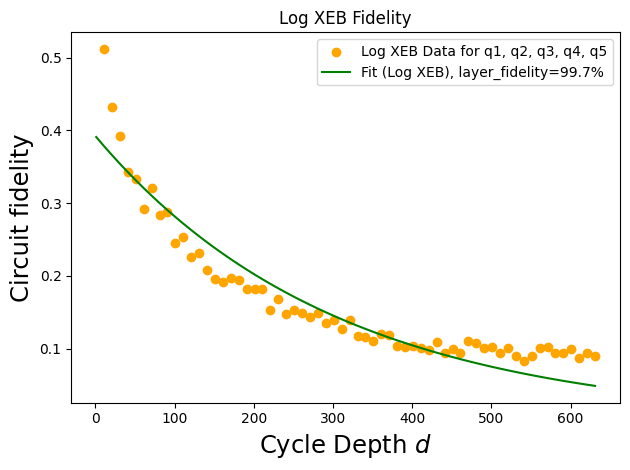

In [449]:
from matplotlib import pyplot as plt
Fxeb = np.nanmean(result.log_fidelities, axis=0)
mask_log = (Fxeb > 0) & (Fxeb < 1)
plt.scatter(xeb_config.depths[mask_log], Fxeb[mask_log], 
            label="Log XEB Data for %s" %", ".join([q.name for q in target_qubits]), color="orange")

from quam_libs.experiments.two_qubit_xeb.macros import fit_exponential_decay, exponential_decay
(a_log, layer_fid_log, a_std_log, layer_fid_std_log,) = fit_exponential_decay(xeb_config.depths, Fxeb)
plt.plot(xeb_config.depths, exponential_decay(xeb_config.depths, a_log, layer_fid_log),
            label="Fit (Log XEB), layer_fidelity={:.1f}%".format(layer_fid_log * 100),
            color="green")

print("fitting error: {:.4f}%".format(a_std_log*100))
plt.ylabel("Circuit fidelity", fontsize=17.5)
plt.xlabel("Cycle Depth $d$", fontsize=17.5)
plt.title("Log XEB Fidelity")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [437]:
# Debugging:  
print(xeb.xeb_config.qubit_pairs)
# print(result.saved_data)

# Singularities Output: (should be of the form [(seq, depth),…] ) 
print("Singularities: %s%%" % (len(result.singularities) / xeb_config.seqs / len(xeb_config.depths) * 100) )
print(result.singularities)
print("Singularities: {:.3f}%" .format(len(result.singularities)/(xeb_config.seqs*len(xeb_config.depths))*100))
      
# print("['counts']['0']: ")
# print(result.saved_data['counts']['0'])

# print("['counts']['1']: ")
# print(result.saved_data['counts']['1'])


[TransmonPair(id='coupler_q1_q2', qubit_control=Transmon(id='q1', xy=MWChannel(operations={'x180_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=0, amplitude=0.16341987647269243, alpha=-0.7828317407801136, anharmonicity=205400000, detuning=0.0), 'x90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=0, amplitude=0.0810483193032584, alpha=-0.6235503408393649, anharmonicity=205400000, detuning=0.0), '-x90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=3.141592653589793, amplitude=0.0810483193032584, alpha=-0.6235503408393649, anharmonicity=205400000, detuning=0.0), 'y180_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=1.5707963267948966, amplitude=0.16341987647269243, alpha=-0.7828317407801136, anharmonicity=205400000, detuning=0.0), 'y90_DragCosine': DragCosinePulse(length=16, id=None, digital_marker='ON', axis_angle=1.5707963267948966, amplitude=0.081048319

In [ ]:
print([readout.operations["readout"].threshold for readout in xeb.readout_channels])

In [8]:
list(xeb.coupling_map.get_edges())

[(0, 2)]

In [ ]:
# result.saved_data["states"]
result.saved_data["amp_matrix_q0"]